# fit_ellipses
- Given a video and events file, fits an ellipse to every detection when possible
- Outputs a file of the fits, with each row corresponding to a different event
- The file structure looks like:

    - (fitting parameters)
    - [event num, [[ellipse center x, ellipse center y], [ellipse axis 1, ellipse axis 2], ellipse angle for detection 1], [detection 2...], etc.]

# Imports

In [1]:
# Python standard library
import sys
import csv

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

# Load data

In [2]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_6/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events_filtered.json'

In [3]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:62: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


# Load template and create stage

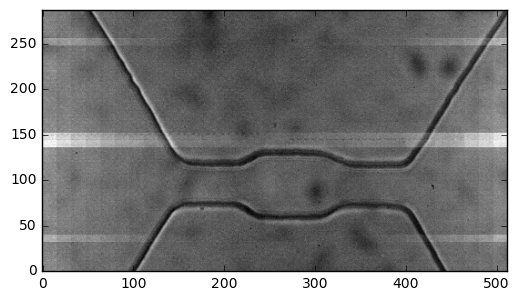

In [4]:
template_index = 0

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

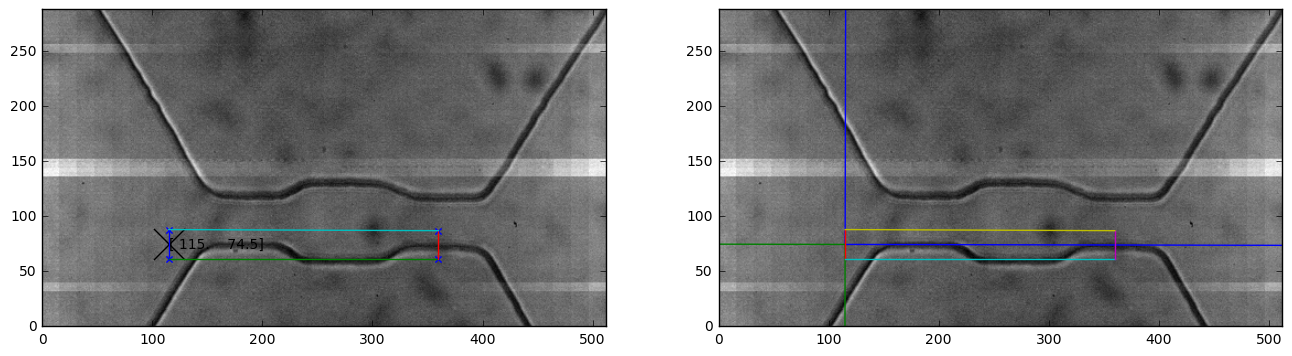

In [5]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [115,88]
c1 = [115,61]
c2 = [360,61]
c3 = [360,87]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Define plotting functions

In [6]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()

# Find a good event to test fitting parameters

In [7]:
oi_index = 16
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

# Define functions

In [8]:
def crop_frame(frame, px, py, crop_distance):    
    x0 = int(px - crop_distance)
    x1 = int(px + crop_distance)
    y0 = int(py - crop_distance)
    y1 = int(py + crop_distance)
    cropped_frame = np.copy(frame)[y0:y1, x0:x1]
    
    return cropped_frame
    

    
    
    
    
    

preprocessing_steps = []
def preprocess_frame(frame, template_frame, detection, debug = False):

    # Refresh list
    del preprocessing_steps[:]

    

    #################################
    # Copy
    #################################
    
    
    
    preprocessing_steps.append(['copy'])

    processed_frame = np.copy(frame)

    if debug:
        print 'copy'
        plot_all(processed_frame, frame)


    #################################
    # Negative
    #################################



    preprocessing_steps.append(['negative'])

    processed_frame = np.abs(frame - template_frame)


    if debug:
        print 'negative'
        plot_all(processed_frame, frame)




    #################################
    # Blur
    #################################


    blur_kernel = (3,3)
    preprocessing_steps.append(['gaussian blur', blur_kernel])

    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)



    if debug:
        print 'gaussian blur'
        plot_all(processed_frame, frame)





    #################################
    # Rescale
    #################################

    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))



    if debug:
        print 'rescale'
        plot_all(processed_frame, frame)






    #################################
    # Threshold
    #################################

    threshold = .15
    preprocessing_steps.append(['pixel intensity threshold', threshold])


    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0




    if debug:
        print 'threshold'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################
    iterations = 1
    preprocessing_steps.append(['erode subtraction, iterations = ', iterations])


    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)




    if debug:
        print 'erode subtraction'
        plot_all(processed_frame, frame)




    #################################
    # Fill holes
    #################################
    preprocessing_steps.append(['fill holes'])

    processed_frame = scipy.ndimage.binary_fill_holes(processed_frame)




    if debug:
        print 'fill holes'
        plot_all(processed_frame, frame)

    #################################    
    # Get largest cluster
    #################################

    preprocessing_steps.append(['clustering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    if debug:
        print 'cluster'
        plot_all(processed_frame, frame)


    #################################
    # Morphological closing
    #################################

    morph_kernel_size = (10,10)
    preprocessing_steps.append(['morphological closing, kernel = ', morph_kernel_size])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)


    if debug:
        print 'morphological closing'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################

    iterations = 3
    preprocessing_steps.append(['erosion subtraction, iterations = ', iterations])



    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations)


    if debug:
        print 'erode subtraction'
        plot_all(processed_frame, frame)
        
    return processed_frame



def fit_ellipse(processed_frame, debug = False):

    #################################
    # Fit ellipse
    #################################



    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[0], cell_pixels[1])
    
    
    if debug:
        ellipse_center = oi.get_ellipse_center(ellipse)
        ellipse_angle = oi.get_ellipse_angle_of_rotation(ellipse)
        ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)





        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes[0]*np.cos(angle)
            y = ellipse_axes[1]*np.sin(angle)
            ellipse_points[i,1] = ellipse_center[0] + np.cos(ellipse_angle)*x - np.sin(ellipse_angle)*y
            ellipse_points[i,0] = ellipse_center[1] + np.sin(ellipse_angle)*x + np.cos(ellipse_angle)*y


        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame



        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 0.5, c = 'yellow')

        plt.xlim(0, frame.shape[1])
        plt.ylim(0, frame.shape[0])

        plt.show()
        
    return ellipse



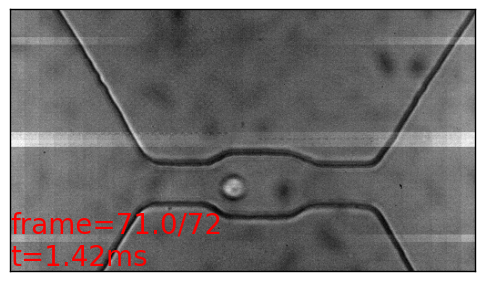

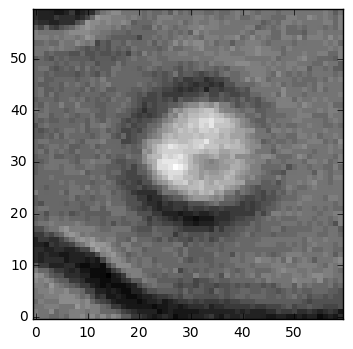

In [9]:
oi_event = oi_events[oi_index]
detection = oi_event._detections[45]
raw_frame = oi_vid.get_frame(detection._tf)

plt.imshow(raw_frame, cmap = 'gray', origin = 'lower')
plt.show()

x0 = int(detection._px - 30)
x1 = int(detection._px + 30)
y0 = int(detection._py - 30)
y1 = int(detection._py + 30)
plt.imshow(raw_frame[y0:y1, x0:x1], cmap = 'gray', origin = 'lower', interpolation = 'none')
plt.show()

# Preprocess, fit ellipse to all detections, calculate aspect ratios at every frame

In [10]:
reload(oi)

<module 'optical_imaging' from '/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.pyc'>

In [11]:
ellipsess = []
detection_indicess = []


for i, oi_event in enumerate(oi_events):
    print i
    
    
    ellipsess.append([])
    detection_indicess.append([])
    
    
    for j, detection in enumerate(oi_event._detections):
        
        try:

            # Get raw frame
            raw_frame = oi_vid.get_frame(detection._tf)


            # Crop frames
            cropped_frame = crop_frame(raw_frame, detection._px, detection._py, 30)
            cropped_template_frame = crop_frame(template_frame, detection._px, detection._py, 30)

            
            # Preprocess frame
            processed_frame = preprocess_frame(cropped_frame, cropped_template_frame, detection, debug = False)

            
            # Get ellipse + parameters
            ellipse = fit_ellipse(processed_frame)
            ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)
            ellipse_center = oi.get_ellipse_center(ellipse)
            ellipse_center[0] = ellipse_center[0] + (detection._px - 30)
            ellipse_center[1] = ellipse_center[1] + (detection._py - 30)
            
            ellipse_angle = oi.get_ellipse_angle(ellipse)




            
            ellipsess[-1].append([j, ellipse_center[0], ellipse_center[1], ellipse_axes[0], ellipse_axes[1], ellipse_angle])

            
        except:
            
            print '\tfailed on', j

0
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
1
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
	failed on 12
	failed on 13
	failed on 14
	failed on 15
	failed on 16
	failed on 17


/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:519: RuntimeWarning: invalid value encountered in sqrt
  res1=np.sqrt(up/down1)


2
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
3
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
	failed on 12
	failed on 13
4
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
5
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
	failed on 12
	failed on 13
	failed on 14
	failed on 15
6
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
7
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:520: RuntimeWarning: invalid value encountered in sqrt
  res2=np.sqrt(up/down2)


9
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
	failed on 12
	failed on 13
	failed on 14
	failed on 15
	failed on 16
10
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
	failed on 12
	failed on 13
	failed on 14
	failed on 15
	failed on 16
11
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
	failed on 12
	failed on 13
12
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8
	failed on 9
	failed on 10
	failed on 11
	failed on 12
	failed on 13
	failed on 14
	failed on 15
	failed on 16
13
	failed on 0
	failed on 1
	failed on 2
	failed on 3
	failed on 4
	failed on 5
	failed on 6
	failed on 7
	failed on 8

# Save ellipses

In [12]:
output_file_path = '../data/' + date + particle + channel + 'ellipses_' + file_index

In [13]:
with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    # Write preprocessing steps
    file_writer.writerow(preprocessing_steps)
    
    # Write ellipse info
    file_writer.writerow(['detection index', 'ellipse center x', 'ellipse center y', 'ellipse axes x', 'ellipse axes y', 'ellipse angle'])
    
    # Write ellipse
    for i, ellipses in enumerate(ellipsess):
        file_writer.writerow(['event #', i])
        for ellipse in ellipses:
            file_writer.writerow(ellipse)